In [104]:
# Our custom module
from nn import DeepQNetwork
from custom_parking_env import ParkingWithObstacles
from relay_mem import ReplayMemory,Transition

# python module
import gymnasium as gym
import torch
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from itertools import count
from IPython import display

# combine observation
def process_observation(observation):
    observation_vector = np.concatenate((
        observation["observation"],
        observation["achieved_goal"],
        observation["desired_goal"]
    ))
    return observation_vector

# interactive mode
plt.ion()

# Create the original environment and wrap it into an environment with obstacles
env_origin = gym.make("parking-v0", render_mode="human")
env = ParkingWithObstacles(env_origin)
env.define_spaces()

# terminated The episode is over if the ego vehicle crashed or the goal is reached or time is over.
terminated = False

# The episode is truncated if the time is over.
truncated = False

# Print the number of states and actions
print(f"Observation Space: {env.observation_space}")
# observation["observation"] Box(-inf, inf, (6,), float64)
# observation["achieved_goal"] Box(-inf, inf, (6,), float64)
# observation["desired_goal"] Box(-inf, inf, (6,), float64)

print(f"Action Space: {env.action_space}")
# Discrete(5)


# Get the number of state observations
state, info = env.reset()

# Get number of actions from gym action space
n_actions = env.action_space.n
n_observations = len(process_observation(state))  # 6 (observation) + 6 (achieved_goal) + 6 (desired_goal)

Observation Space: Dict('achieved_goal': Box(-inf, inf, (6,), float64), 'desired_goal': Box(-inf, inf, (6,), float64), 'observation': Box(-inf, inf, (6,), float64))
Action Space: Discrete(5)


In [ ]:
# if GPU is to be used
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 2
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
# EPS_DECAY = 1000
# TAU = 0.005
TARGET_UPDATE = 50
LR = 1e-4
EPISODES = 100

policy_net = DeepQNetwork(n_observations, n_actions).to(device)
target_net = DeepQNetwork(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

# Training loop
num_episodes = EPISODES
epsilon_decay_rate = -np.log(EPS_END / EPS_START) / num_episodes
epsilon_values = []
episode_rewards = []  # Store total rewards per episode
losses = []
episode_durations = []

Using CPU


In [106]:
steps_done = 0
def select_action(state , i_episode):
    global steps_done
    sample = random.random()
    epsilon_threshold = EPS_START * np.exp(-epsilon_decay_rate * i_episode)
    epsilon_values.append(epsilon_threshold)
    steps_done += 1
    if sample > epsilon_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def optimize_policy_net():
    # Check if enough transitions are available in replay_buffer
    if len(memory) < BATCH_SIZE:
        return

    # Sample a batch of transitions
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(
                        tuple(map(lambda s: s is not None,
                        batch.next_state)), 
                        device=device, 
                        dtype=torch.bool)
    
    non_final_next_states = []
    for s in batch.next_state:
        if s is not None:  # Check if s is not None
            non_final_next_states.append(s)  # Add elements that meet the condition to the list
    
    if len(non_final_next_states) == 0 :
        # Use a placeholder tensor with the appropriate shape
        # Assuming the state has a known shape, e.g., (batch_size, state_dim)
        non_final_next_states = torch.empty((0, *batch.state[0].shape ), device=device)

    # RuntimeError: torch.cat(): expected a non-empty list of Tensors
    non_final_next_states = torch.cat(non_final_next_states)
    
    # Concatenate batch tensors
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the policy network
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    # for param in policy_net.parameters():
    #     param.grad.data.clamp_(-1, 1)
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    # Track the loss for plotting
    losses.append(loss.item())
    print(f"Loss: {loss.item()}")

def moving_average(data, window_size=50):
    # convolution
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_training_durations():
    # Create a new figure for the plot
    plt.clf()

    # Convert episode rewards to tensors
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float, device=device)

    # Plot rewards per episode
    plt.subplot(3, 1, 1)
    plt.title('Training Progress (Per Episode)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    # Move GPU tensor back to CPU and convert it to NumPy
    plt.plot(rewards_t.cpu().numpy(), label="Total Reward")
    
    # Add smoothed rewards
    if len(episode_rewards) >= 50:  # Ensure enough data for smoothing
        smoothed_rewards = moving_average(episode_rewards, window_size=50)
        plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Rewards", color='orange')
    plt.legend()

    # Plot losses per step
    plt.subplot(3, 1, 2)
    plt.title('Loss (Per Step)')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.plot(losses, label="Loss", color='red')
    plt.legend()

    # Plot epsilon decay per step
    plt.subplot(3, 1, 3)
    plt.title('Epsilon Decay (Per Step)')
    plt.xlabel('Training Step')
    plt.ylabel('Epsilon')
    plt.plot(epsilon_values, label="Epsilon Decay", color='blue')
    plt.legend()

    # Adjust layout to increase space between plots
    plt.subplots_adjust(hspace=0.5)  # Adjust spacing between rows

    # Pause briefly to update the plot
    plt.pause(0.01)

    # Clear the current output and display the updated plot
    display.display(plt.gcf())

Loss: 0.08648580833138422
Loss: 0.07286334818336958
Loss: 0.08402936261320626
Loss: 0.033677930585119004
Loss: 0.06814788261532637
Loss: 0.06952555691265852
Loss: 0.054922042782113906


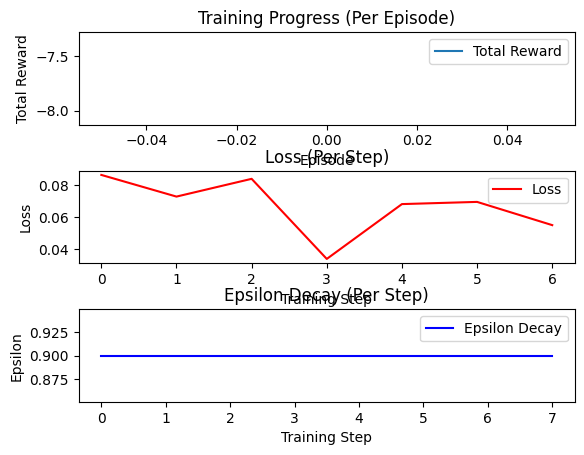

<Figure size 640x480 with 0 Axes>

1 / 100 , R=  -7.70351480939016
Loss: 0.04681700801912307
Loss: 0.05705711375705588
Loss: 0.05799360618018347
Loss: 0.03471043953548977
Loss: 0.02791037970758177
Loss: 0.07118795112452943
Loss: 0.10788468756790413
Loss: 0.04530404517664289
2 / 100 , R=  -9.1697334114825
Loss: 0.04752658359669244
Loss: 0.09151603341265382
Loss: 2.398663731005368
Loss: 0.06430942820638916
Loss: 0.07487139478767749
Loss: 0.051505610481426156
Loss: 0.051740051023339007
Loss: 0.05283592334978392
3 / 100 , R=  -8.710611485361152
Loss: 0.07289294093477111
Loss: 0.029479700332801617
Loss: 0.10727402278004299
Loss: 0.029320515679423835
Loss: 0.07484144282189802
Loss: 0.09586030604168694
Loss: 2.6374884571249915
Loss: 0.03172824175865842
Loss: 2.3782793873692865
Loss: 0.039125917790250195
Loss: 0.05854197707951441
Loss: 0.02915786892892211
Loss: 0.028186165308698965
Loss: 0.0465426793979321
Loss: 0.08244173949945328
4 / 100 , R=  -11.401193287282943
Loss: 0.04530144068301548
Loss: 0.06899789900575082
Loss: 0.066

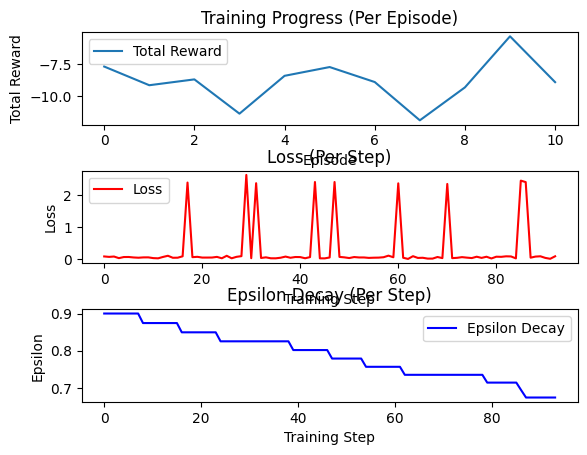

<Figure size 640x480 with 0 Axes>

11 / 100 , R=  -8.928089231852388
Loss: 0.04009478067301604
Loss: 0.101492278963701
Loss: 0.057781985320695214
Loss: 2.4675526278069007
Loss: 0.05682034458004119
Loss: 0.03991197119974353
Loss: 2.376128374428127
12 / 100 , R=  -8.313677657176935
Loss: 0.09089948249557252
Loss: 0.04945683917291329
Loss: 0.05890078847738915
Loss: 0.00832899020579479
Loss: 0.09013040481698535
Loss: 0.10253434955203997
Loss: 0.04111526339303388
13 / 100 , R=  -8.043078926423208
Loss: 0.07013983189649522
Loss: 0.08922084644018455
Loss: 0.046583817587398935
Loss: 0.017036976826194893
Loss: 0.10848434704086911
Loss: 2.462960778796725
Loss: 0.058864490732386594
14 / 100 , R=  -7.611717424994142
Loss: 0.013817041821942133
Loss: 2.383331218502119
Loss: 0.07021184245961355
Loss: 0.06702063320836146
Loss: 0.058542285914321805
Loss: 0.038506994778314846
Loss: 0.04380605074467495
Loss: 0.13080268534192613
15 / 100 , R=  -7.9195610277541935
Loss: 0.06514825987826449
Loss: 2.2618583467993965
Loss: 0.10618038082848963


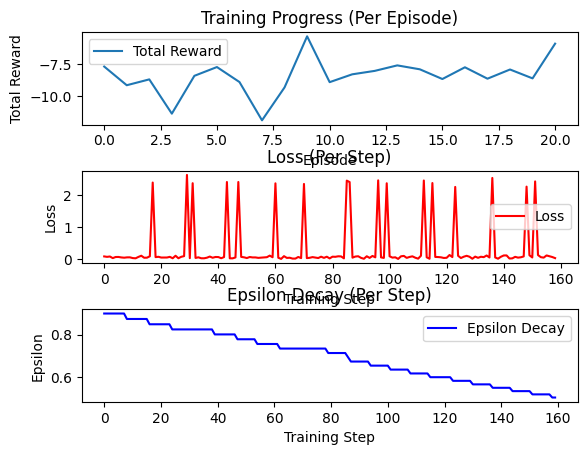

<Figure size 640x480 with 0 Axes>

21 / 100 , R=  -5.9062123201980095
Loss: 0.1076772555509816
22 / 100 , R=  -5.45528294086091
Loss: 0.10126029835916006
Loss: 0.12106777341435324
Loss: 0.08166036261632535
Loss: 0.06988683055772028
Loss: 0.13344724129567878
Loss: 0.03205595090078352
Loss: 0.06227008376597042
23 / 100 , R=  -8.676846050763107
Loss: 0.08955351315567071
Loss: 0.11426004141186956
Loss: 0.12385892010785016
Loss: 0.10721749752781329
Loss: 0.059278169018389046
Loss: 0.10875311174135265
Loss: 0.09240177848245126
24 / 100 , R=  -6.732831889878277
Loss: 0.09027804900174101
Loss: 0.10419683832450573
Loss: 0.07412551134698542
Loss: 0.0563982532389284
Loss: 2.2841862062100287
Loss: 0.055043123575911415
Loss: 2.333628965996724
25 / 100 , R=  -7.966961309566424
Loss: 0.13454211903407481
26 / 100 , R=  -5.5146354459533695
Loss: 0.11369250579786527
Loss: 0.07107839305597013
Loss: 0.04625285135604681
Loss: 2.4021223616045915
Loss: 0.07374498775689882
Loss: 0.07928634627786726
Loss: 0.07678790038942154
Loss: 0.05214607203

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

<Figure size 640x480 with 0 Axes>

In [107]:
for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    observation, info = env.reset()
    observation_vector = process_observation(observation)
    observation_tensor = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)
    
    total_reward = 0  # Track total reward for this episode

    for t in count():
        action = select_action(observation_tensor,i_episode)
        observation, reward, done, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        total_reward += reward.item()  # Accumulate rewards

        if done:
            next_state = None
        else:
            observation_vector = process_observation(observation)
            next_state = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(observation_tensor, action, next_state, reward)

        # Move to the next state
        observation_tensor = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_policy_net()

        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(total_reward)  # Save total reward for this episode
            if i_episode % 10 == 0:
                plot_training_durations()
            break

        # Update target network
        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
    
    print(i_episode + 1,'/',num_episodes, ', R= ', episode_rewards[i_episode])

print('Training is finished')
plt.ioff()
plt.show()

In [ ]:
# # Initialize the environment and get its state
# observation, info = env.reset()
# observation_vector = process_observation(observation)
# observation_tensor = torch.tensor(observation_vector, dtype=torch.float32, device=device).unsqueeze(0)
# print(observation_tensor.shape)
# print(info)

# action = select_action(observation_tensor,i_episode)
# print(action)

# observation, reward, done, truncated, _ = env.step(action.item())
# print(observation)
# print(done)

# reward = torch.tensor([reward], device=device)
# print(reward)
# out = env.compute_reward(observation["achieved_goal"],observation["desired_goal"],{})
# print(out > -env.config["success_goal_reward"])

In [108]:
env.close()

In [ ]:
# print(len(memory.memory))